In [71]:
import svgwrite
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pandas as pd


# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
data = np.load("cloud.npz", encoding="latin1", allow_pickle=True)
train = data["train"]

In [60]:
# helper function for draw_strokes
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in xrange(len(data)):
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)
    
    return (min_x, max_x, min_y, max_y)

# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=2, svg_filename = 'sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(0,20):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "red"
    stroke_width = 2
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    for i in xrange(20,len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=15.0):
    
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
  
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

In [139]:
from typing import List, Tuple
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

def create_window(input_data: np.array, window_size: int) -> np.array:
    data_len = len(input_data)
    result = np.zeros((data_len-window_size+1, window_size, *input_data.shape[1:]))
    for i in range(data_len):
        if i+window_size <= data_len:
            result[i] = input_data[i:i+window_size]
    return result


def create_window_on_multiple_samples(input_data: np.array, window_size: int) -> np.array:
    """
    Similar to create_window, but now can take multiple samples, will output in one
    giant windowed np.array.
    """
    windowed_data = []
    for i, sample in enumerate(input_data):
        windowed_data.append(create_window(sample[:,:2], window_size))
        if i % 10000 == 0:
            print(f"Now at {i}")
            clear_output(wait=True)
    result = np.concatenate(windowed_data)
    print(f"Done processing {i} samples, total of {result.shape[0]} windows and {result.shape[0] * result.shape[1]} datapoints")
    return np.concatenate(windowed_data)


def split_train_test(input_data: List) -> Tuple[np.array, np.array]:
#     return input_data[:,0:-1], input_data[:,-1]
    return input_data[:,:-1], input_data[:,-1]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    scaler = MinMaxScaler()
    normalised_data = []
    for i, window in enumerate(window_data):
        scaled = scaler.fit_transform(window)
        normalised_data.append(scaled)
        if i % 10000 == 0:
            print(f"Now at {i}")
    return np.concatenate(normalised_data)

In [140]:
x = create_window_on_multiple_samples(train, 20)

Done processing 69999 samples, total of 2832224 windows and 56644480 datapoints


In [147]:
X, Y = split_train_test(x)

In [148]:
x[0]

array([[  1., -42.],
       [  5., -10.],
       [ 28., -21.],
       [ 29.,  -8.],
       [ 47.,   1.],
       [ 19.,  10.],
       [  2.,  12.],
       [-11.,  15.],
       [ 10.,   2.],
       [ 92.,  -5.],
       [137.,   0.],
       [  3.,   5.],
       [ -7.,   3.],
       [-16.,  17.],
       [130.,  -1.],
       [  6.,   5.],
       [ -1.,  13.],
       [ -4.,   9.],
       [-22.,  22.],
       [ 50.,  -4.]])

In [146]:
print(f" x = {X[0]} \t y = {Y[0]}")

 x = [[  1. -42.]
 [  5. -10.]
 [ 28. -21.]
 [ 29.  -8.]
 [ 47.   1.]
 [ 19.  10.]
 [  2.  12.]
 [-11.  15.]
 [ 10.   2.]
 [ 92.  -5.]
 [137.   0.]
 [  3.   5.]
 [ -7.   3.]
 [-16.  17.]
 [130.  -1.]
 [  6.   5.]
 [ -1.  13.]
 [ -4.   9.]
 [-22.  22.]] 	 y = [50. -4.]


In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

# Initialize LSTM
model = Sequential()
# print (train_set[3].shape)
model.add(LSTM(units=10, return_sequences=True,
     input_shape=(X.shape[0], 2)))

# Adding a second LSTM layer and Dropout regularisation
# model.add(LSTM(units = 20, return_sequences = True))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 2))
print(model.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 410, 10)           520       
_________________________________________________________________
dense_31 (Dense)             (None, 410, 2)            22        
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
410/410 - 3s - loss: 602.4587
Epoch 2/100
410/410 - 2s - loss: 598.4556
Epoch 3/100
410/410 - 2s - loss: 595.2673
Epoch 4/100
410/410 - 1s - loss: 592.2997
Epoch 5/100
410/410 - 2s - loss: 589.3425
Epoch 6/100
410/410 - 2s - loss: 586.5099
Epoch 7/100
410/410 - 2s - loss: 583.2643
Epoch 8/100
410/410 - 2s - loss: 578.8501
Epoch 9/100
410/410 - 2s - loss: 574.1293
Epoch 10/100
410/410 - 2s - loss: 569.5025
Epoch 11/100
410/410 - 2s - loss: 565.0029
Epoch 12/100
410/410 - 2s - loss: 559.8824
Epoch 13/100
410/410 - 2s - loss: 555.8026
Epoch 14/100
410/410 - 2s - loss: 550.0955
Epoch 15/100
410/410 - 2s - loss: 550.0093
Epoch 16/100
410/410 - 2s - loss: 542.2171
Epoch 17/100
410/410 - 2s - loss: 539.6564
Epoch 18/100
410/410 - 2s - loss: 536.1525
Epoch 19/100
410/410 - 2s - loss: 532.2631
Epoch 20/100
410/410 - 2s - loss: 528.0716
Epoch 21/100
410/410 - 2s - loss: 524.8795
Epoch 22/100
410/410 - 2s - loss: 527.2990
Epoch 23/100
410/410 - 2s - loss: 519.6730
Epoch 24/100
410/410

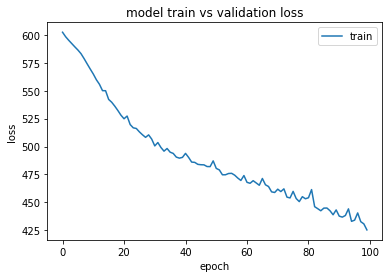

In [142]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X, Y, epochs=100, batch_size=1, verbose=2)
# history = model.fit(X, Y, epochs = 100)

# plot train and validation loss
pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [99]:
ts = model.predict(X)
X.shape

(410, 19, 2)

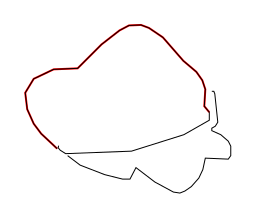

In [78]:
# print(f"test {ts[0]} \t x = {X[0]} ")
draw_strokes(train[2])
# draw_strokes(train[0])

